# ¿Cuál es la mejor tarifa?

El operador de telecomunicaciones Megaline ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de los planes genera más ingresos para poder ajustar el presupuesto de publicidad.

Este proyecto es un análisis preliminar de las tarifas de megaline: Ultimate y Surf,  basado en una selección de 500 clientes de la compañia del año 2018.

Se va a analizar el comportamiento de los clientes y con esto se va a determinar qué tarifa de prepago genera más ingresos.
Determinar qué plan, en promedio, aporta más ingresos es una cuestión que se abordará mediante pruebas estadísticas.

#### Procedimiento a realizar:
1. Se hará la carga de librerias necesarias
2. Se hará la carga de los datos necesarios para trabajar
3. Se explora cada uno de los DF para tener una comprensión inicial de los datos y de ser necesario, corregir psibles errores en ellos. Esto involucra:
   - Corregir errores de lectura (si los hay)
   - Corregir nombres de columna y tipos de dato de las tablas
   - Buscar valores ausentes
   - Buscar y corregir filas total y parcialmente duplicadas.
   - Enriquecer los datos: Usar ingeniería de características para crear nuevas columnas en los DF que puedan ser útiles para el análisis
4. Los DF calls, messages e internet contienen información de las llamadas, mensajes e internet que gastaron los usuarios a lo largo del mes. 
 1. Se fusionarán estos DF con la información de los usuarios y su plan contratado correspondiente para obtener el consumo total mensual por usuario y por plan
 2. Usando la información obtenida en el paso uno, se calcularán las cuotas totales mensuales de acuerdo a las condiciones de las tarifas de los planes surf y ultimate
5. Se analizará estadísticamente los minutos, llamadas y gigabytes mensuales consumidos por los clientes de los dos planes. Se compararán estos resultados para analizar el comportamiento de los usuarios de ambos planes.
6. Se compararán las ganancias mensuales obtenidas por ambos planes.
7. Realizaremos una prueba de hipotesis para asegurar estadísticamente si las ganancias entre planes son iguales o distintas, ya sea por plan, o por regiones.
 1. Haremos una prueba para determinar si las ganancias mensuales entre los planes surf y ultimate difieren entre sí
 2. Haremos una prueba para determinar si las ganancias mensuales de la región NY-NJ son similares en comparación con las ganancias de las demás regiones.

## Inicialización

In [1]:
# Se cargan todas las librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import math
import seaborn as sns

## Cargar datos

In [3]:
# Se cargan los archivos de datos en diferentes DataFrames
users = pd.read_csv('../datasets/megaline_users.csv')
calls = pd.read_csv('../datasets/megaline_calls.csv')
messages = pd.read_csv('../datasets/megaline_messages.csv')
internet = pd.read_csv('../datasets/megaline_internet.csv')
plans = pd.read_csv('../datasets/megaline_plans.csv')

## Preparar los datos

### Tarifas

In [4]:
# Información general/resumida sobre el DF de las tarifas
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 260.0+ bytes


In [5]:
# Muestra de los datos para las tarifas
display(plans) # solo tiene 2 entradas así que imprimimos todo el DF

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


Nos damos cuenta que los datos están correctamente leídos, los encabezados son correctos, así como el tipo de dato para cada columna.
No hay valores NaN o ausentes.

#### Corregir datos

No se encontraron problemas con los datos para este DF

#### Enriquecer los datos

Este DF es meramente informativo y los datos son correctos con los planes de megaline.

### Usuarios/as

In [6]:
# Información general/resumida sobre el DataFrame de usuarios
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [7]:
# Imprime una muestra de datos para usuarios
display(users.sample(15, random_state=5895))

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
259,1259,Etsuko,Perry,63,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",2018-03-16,surf,NaN
25,1025,Jess,Wilkinson,64,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-10-28,ultimate,NaN
158,1158,Robin,Thornton,20,"Virginia Beach-Norfolk-Newport News, VA-NC MSA",2018-11-30,ultimate,NaN
281,1281,Zack,Hardy,39,"Charlotte-Concord-Gastonia, NC-SC MSA",2018-07-23,surf,2018-11-14
306,1306,Darron,Craig,19,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA",2018-11-26,surf,NaN
130,1130,Clarence,Cunningham,27,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",2018-05-17,surf,NaN
127,1127,Marchelle,Brock,28,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-06-23,surf,NaN
272,1272,Ernest,Mercado,23,"Minneapolis-St. Paul-Bloomington, MN-WI MSA",2018-08-04,surf,NaN
355,1355,Digna,Tyson,57,"Los Angeles-Long Beach-Anaheim, CA MSA",2018-10-07,surf,NaN
301,1301,Tomas,Horton,64,"Chicago-Naperville-Elgin, IL-IN-WI MSA",2018-01-04,ultimate,NaN


Se aprecia que los datos fueron leidos correctamente, las columnas son correctas, así como sus tipos de dato, pero:

- Falta buscar por valores duplicados en el DF y en la columna 'user_id'
- Las columnas 'reg_date' y 'churn_date' se representarían mejor con un tipo de dato datetime
- Hay valores ausentes en churn_date, para lo cual debemos investigar la naturaleza de los datos de esta columna.

#### Corregir los datos

In [8]:
# Buscamos valores duplicados en el DF:
print('Duplicados user_id: ', users['user_id'].duplicated().sum()) 
print('Duplicados totales:', users.duplicated().sum())

# Cambiamos 'reg_date' a datetime:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
# cambiamos 'churn_date' a datetime:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d', errors='coerce')
    # NOTA: Dado que ahora 'churn_date' es tipo datetime, no cambiamos los NaT, para posteriormente poder acceder a 
    # los atributos como día, o mes de aquellos no son NaT

# Visualizamos para verificar cambios
print(users.dtypes) # ahora tenemos datos tipo datetime
display(users.sample(5, random_state=5895))

Duplicados user_id:  0
Duplicados totales: 0
user_id                int64
first_name            object
last_name             object
age                    int64
city                  object
reg_date      datetime64[ns]
plan                  object
churn_date    datetime64[ns]
dtype: object


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
259,1259,Etsuko,Perry,63,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA",2018-03-16,surf,NaT
25,1025,Jess,Wilkinson,64,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-10-28,ultimate,NaT
158,1158,Robin,Thornton,20,"Virginia Beach-Norfolk-Newport News, VA-NC MSA",2018-11-30,ultimate,NaT
281,1281,Zack,Hardy,39,"Charlotte-Concord-Gastonia, NC-SC MSA",2018-07-23,surf,2018-11-14
306,1306,Darron,Craig,19,"Washington-Arlington-Alexandria, DC-VA-MD-WV MSA",2018-11-26,surf,NaT


#### Enriquecer los datos

Mas adelante, compararemos el ingreso promedio de los usuarios del área NY-NJ con respecto al ingreso de los usuarios de otras regiones, por lo que añadiremos a la tabla users la columna 'ny_nj', la cual contendrá True si el usuario pertenece a esa región y False si no.

In [9]:
# Creamos la nueva columna con los booleanos requeridos:
users['ny_nj'] = users['city'].str.contains('NY-NJ')
display(users.head()) # Visualizamos la nueva columna en el DF

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,ny_nj
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaT,False
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaT,False
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaT,False
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaT,False
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaT,False


### Llamadas

In [10]:
# Información general/resumida sobre el DataFrame de las llamadas
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [11]:
# Muestra de datos para las llamadas
display(calls.sample(5, random_state=78521))

,id,user_id,call_date,duration
25816,1099_136,1099,2018-07-09,2.72
39355,1147_80,1147,2018-07-22,0.00
31758,1120_100,1120,2018-09-20,6.21
61543,1222_190,1222,2018-07-11,7.65
27995,1106_335,1106,2018-09-07,0.00


No se ven datos ausentes en ninguna columna. Sin embargo:

- Falta buscar datos duplicados.
- La columna 'id' se representaría mejor por un tipo de dato int64, para ser congruente con los id's de DF's anteriores.
- En la descripción de las tarifas del negocio, se nos explica que para llamadas, Megaline redondea los segundos a  minutos, por lo tanto, la columna 'duration' debe estar redondeada hacia arriba y ser un tipo de dato entero.

#### Corregir los datos

In [12]:
## Buscamos por datos duplicados en el DF:
print('Duplicados totales: ',calls.duplicated().sum()) # Duplicados totales: 0
print('Duplicados en "id":', calls['id'].duplicated().sum()) # Duplicados en 'id': 0

# Cambiamos el tipo de dato de la columna 'id':
try:
    calls['id'] = calls['id'].str.replace('_','')
    calls['id'] = pd.to_numeric(calls['id'])
except: 
    print('La columna id ya es int64')
# Redondeamos la columna duration hacia el valor inmediato superior y convertimos la columna de float a tipo entero:
calls['rounded_duration'] = calls['duration'].apply(math.ceil).astype('int64')

# imprimimos de nuevo para verificar cambios
display(calls.dtypes) 
display(calls.sample(5, random_state=78521))

Duplicados totales:  0
Duplicados en "id": 0


id                    int64
user_id               int64
call_date            object
duration            float64
rounded_duration      int64
dtype: object

,id,user_id,call_date,duration,rounded_duration
25816,1099136,1099,2018-07-09,2.72,3
39355,114780,1147,2018-07-22,0.00,0
31758,1120100,1120,2018-09-20,6.21,7
61543,1222190,1222,2018-07-11,7.65,8
27995,1106335,1106,2018-09-07,0.00,0


#### Enriquecer los datos

In [13]:
## Vemos que a la columna call_date podrían representarse mejor por el tipo de dato datetime:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
print(calls['call_date'].dtype) # Comprobamos que ahora el tipo de dato es datetime

# Creamos una columna llamada month donde indique el mes en el que se realizó la llamada:
calls['month'] = calls['call_date'].dt.month

# Visualizamos la versión final de la tabla calls:                        
display(calls.sample(5, random_state=78521))

datetime64[ns]


,id,user_id,call_date,duration,rounded_duration,month
25816,1099136,1099,2018-07-09,2.72,3,7
39355,114780,1147,2018-07-22,0.00,0,7
31758,1120100,1120,2018-09-20,6.21,7,9
61543,1222190,1222,2018-07-11,7.65,8,7
27995,1106335,1106,2018-09-07,0.00,0,9


### Mensajes

In [14]:
# Información general/resumida sobre el DataFrame de los mensajes
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [15]:
# Imprime una muestra de datos para los mensajes
display(messages.sample(5, random_state=68975))

,id,user_id,message_date
23864,1144_353,1144,2018-12-05
49555,1328_513,1328,2018-08-28
57819,1364_140,1364,2018-11-02
5551,1052_308,1052,2018-12-05
11996,1079_395,1079,2018-12-14


Los datos estan correctamente leidos y no hay valores ausentes. Falta:
- Verificar por valores duplicados
- Corregir el tipo de dato de la columna 'id': de object a int64
- Corregir el tipo de dato de 'message_date': de object a datetime

#### Corregir los datos

In [16]:
## Buscamos duplicados
print('Duplicados totales: ',messages.duplicated().sum()) 
print('Duplicados en "id": ', messages['id'].duplicated().sum())

## Corregimos el tipo de dato de id:
try:
    messages['id'] = messages['id'].str.replace('_', '')
    messages['id'] = pd.to_numeric(messages['id'])
except: 
    print('La columna id ya es int64')

## Convertimos 'message_date' a datetime
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

## imprimimos los tipos de dato para verificar las conversiones de tipos:
print(messages.dtypes)

Duplicados totales:  0
Duplicados en "id":  0
id                       int64
user_id                  int64
message_date    datetime64[ns]
dtype: object


#### Enriquecer los datos

In [17]:
## Creamos una nueva columna, 'month' en el DF para visualizar el mes del mensaje:
messages['month'] = messages['message_date'].dt.month
print(messages['month'].dtype)

## visualizamos la muestra para ver el DF actualizado:
display(messages.sample(5, random_state=68975))

int32


,id,user_id,message_date,month
23864,1144353,1144,2018-12-05,12
49555,1328513,1328,2018-08-28,8
57819,1364140,1364,2018-11-02,11
5551,1052308,1052,2018-12-05,12
11996,1079395,1079,2018-12-14,12


### Internet

In [18]:
# Información general/resumida sobre el DataFrame de internet
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [19]:
# Imprime una muestra de datos para el tráfico de internet
display(internet.sample(5, random_state=159768))

,id,user_id,session_date,mb_used
47116,1210_332,1210,2018-07-05,269.50
60095,1270_420,1270,2018-10-24,446.75
43668,1194_86,1194,2018-10-18,842.22
40805,1182_587,1182,2018-11-16,717.19
86322,1400_459,1400,2018-12-16,214.88


No hay valores ausentes, pero:
- Hace falta buscar por duplicados en el DF
- El tipo de dato de la columna 'id' se puede cambiar por int64
- El tipo de dato de 'session_date' se puede cambiar por datetime.

#### Corregir los datos

In [20]:
## Buscamos duplicados en el DF
print('Duplicados totales: ', internet.duplicated().sum()) # Duplicados totales: 0
print('Duplicados en id: ',internet['id'].duplicated().sum()) # Duplicados en id: 0

## Cambiamos el tipo de dato de 'id':
try:
    internet['id'] = internet['id'].str.replace('_','')
    internet['id'] = pd.to_numeric(internet['id'])
except: 
    print('La columna id ya es int64')

# Cambiamos el tipo de dato de 'session_date'
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

## imprimimos los tipos de dato para verificar las conversiones de tipos:
print(internet.dtypes)

Duplicados totales:  0
Duplicados en id:  0
id                       int64
user_id                  int64
session_date    datetime64[ns]
mb_used                float64
dtype: object


#### Enriquecer los datos

In [21]:
## Creamos una nueva columna, month, para ver el mes en el que se realizó la sesión web:
internet['month'] = internet['session_date'].dt.month

# Visualizamos la nueva versión del DF:
display(internet.sample(5, random_state=159768))

,id,user_id,session_date,mb_used,month
47116,1210332,1210,2018-07-05,269.50,7
60095,1270420,1270,2018-10-24,446.75,10
43668,119486,1194,2018-10-18,842.22,10
40805,1182587,1182,2018-11-16,717.19,11
86322,1400459,1400,2018-12-16,214.88,12


## Estudiar las condiciones de las tarifas

In [22]:
# Condiciones de las tarifas de megaline:
display(plans)

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Agregar datos por usuario
Creamos un solo registro ***'ingreso_mensual_usuarios'*** que recopile los datos por usuario y por periodo de las llamadas, minutos, mensajes y gigabytes usados por usuario y por mes. Así como también, recopile la información de las cuotas mensuales cobradas a los usuarios (los ingresos de la empresa), de acuerdo a las condiciones de las tarifas.

Comenzamos por hacer un recuento de los consumos totales por mes y por usuario de llamadas, minutos, mensajes y gigabytes:

In [24]:
# Se calcula el número de llamadas hechas por cada usuario al mes. 
    ## Para ello filtramos la Tabla calls: user_id/month. Sobre 'id' aplicamos count(). 

# Se calcula la cantidad de minutos usados por cada usuario al mes.
    ## Para ello filtramos la Tabla calls: user_id/month. Sobre 'rounded_duration' aplicamos sum(). 
### Forma 1: Con groupby.
calls_recount = calls.groupby(['user_id', 'month']).agg({'id': 'count', 'rounded_duration': 'sum'})
calls_recount.rename(columns={'id': 'llamadas', 'rounded_duration': 'minutos'}, inplace=True)
display(calls_recount)

### Forma 2: Con una pivot Table.
calls_table = calls.pivot_table(index='user_id',
                            columns='month',
                            values=['id','rounded_duration'],
                            aggfunc=['count','sum']
                           )
#display(calls_table)

llamadas  minutos
user_id month                   
1000    12           16      124
1001    8            27      182
        9            49      315
        10           65      393
        11           64      426
...                 ...      ...
1498    12           39      339
1499    9            41      346
        10           53      385
        11           45      308
        12           65      496

[2258 rows x 2 columns]

In [25]:
# Se calcula el número de mensajes enviados por cada usuario al mes.
    ## Filtramos la Tabla messages: user_id/month. Sobre 'id' aplicamos count(). 
messages_recount = messages.groupby(['user_id','month']).agg({'id': 'count'})
messages_recount.rename(columns={'id': 'mensajes'}, inplace = True)
#display(messages_recount)

In [26]:
# Se calcula el volumen del tráfico de Internet usado por cada usuario al mes.

## Antes de filtrar hacemos una función que redondee los mb usados, Para el trafico web, 
## Megaline redondea el total del mes hacia arriba. Si alguien usa 1025 megabytes este mes, se le cobrarán 2 gigabytes.
def redondear_gb(x_megas):
    # Los GB se forman por multiplos de 1024 MB
    x_gigas = math.ceil(x_megas/1024)
    return x_gigas

## Filtramos la Tabla Internet: user_id/month. Sobre 'mb_used' aplicamos sum(). 
internet_recount = internet.groupby(['user_id', 'month']).agg({'mb_used': 'sum'})
internet_recount.rename(columns = {'mb_used': 'megabytes'}, inplace = True)
internet_recount['gigabytes'] = internet_recount['megabytes'].apply(redondear_gb) # Aplicamos redondear_gb para redondear a gb
#display(internet_recount)

Fusionamos los recuentos anteriores en un solo DF, consumo_mensual.
A este DF le añadimos la información de usuario, para saber a que plan pertenece cada usuario:

In [27]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month
## Aplicamos un outer merge:
fusion1 = pd.merge(calls_recount, messages_recount, left_index=True, right_index=True, how = 'outer')
#display(fusion1)
consumo_mensual = pd.merge(fusion1, internet_recount, left_index=True, right_index=True, how = 'outer')
consumo_mensual = consumo_mensual.reset_index()
#display(consumo_mensual)

# Añadimos información del plan de la tabla users
consumo_mensual_plan = users[['user_id','plan']].merge(consumo_mensual, on='user_id', how='right')
#display(consumo_mensual_plan)

## Llenamos los nan con 0, pues en esas celdas, los clientes no usaron minutos/mensajes/internet
consumo_mensual_plan.fillna(0, inplace=True)
display(consumo_mensual_plan)

,user_id,plan,month,llamadas,minutos,mensajes,megabytes,gigabytes
0,1000,ultimate,12,16.0,124.0,11.0,1901.47,2.0
1,1001,surf,8,27.0,182.0,30.0,6919.15,7.0
2,1001,surf,9,49.0,315.0,44.0,13314.82,14.0
3,1001,surf,10,65.0,393.0,53.0,22330.49,22.0
4,1001,surf,11,64.0,426.0,36.0,18504.30,19.0
...,...,...,...,...,...,...,...,...
2288,1498,surf,12,39.0,339.0,0.0,23137.69,23.0
2289,1499,surf,9,41.0,346.0,0.0,12984.76,13.0
2290,1499,surf,10,53.0,385.0,0.0,19492.43,20.0
2291,1499,surf,11,45.0,308.0,0.0,16813.83,17.0


Finalmente, se calculan los ingresos mensuales por usuario.
Para ello debemos calcular los costos por minutos extra, gb extra y mensajes extra que deben pagar los usuarios (si es que se excedieron de su plan) de acuerdo a las cuotas de cada plan. 
A estos costos hay que sumarle la cuota mensual del plan para obtener la cuota total a pagar por usuario.

In [28]:
# Calcula el ingreso mensual para cada usuario
ingreso_mensual = plans.merge(consumo_mensual_plan,
                              left_on='plan_name',
                              right_on='plan', how='right')
ingreso_mensual.drop('plan', axis='columns', inplace = True)
#display(ingreso_mensual)

# Cambiamos la unidad de medida de mb_per_month_included a gb_per_month_included:
ingreso_mensual['mb_per_month_included'] = ingreso_mensual['mb_per_month_included']/1024
ingreso_mensual.rename(columns = {'mb_per_month_included': 'gb_per_month_included'}, inplace = True)
#display(ingreso_mensual)

# Contabilizamos el excedente de minutos a lo largo del mes:
def exceso_minutos(fila):
    if fila['minutes_included'] >= fila['minutos']:
        return 0
    else:
        exceso_minutos = fila['minutos']-fila['minutes_included'] # Cuantos minutos se excedió el cliente del plan
        return exceso_minutos* fila['usd_per_minute'] # costo extra por los minutos excedidos
ingreso_mensual['extra_minutos']= ingreso_mensual.apply(exceso_minutos, axis = 1) # Aplicamos la función
print(ingreso_mensual[ingreso_mensual['extra_minutos']>0]['extra_minutos'].count(),' personas excedieron su plan de minutos')

# Contabilizamos el excedente de mensajes a lo largo del mes:
def exceso_mensajes(fila):
    if fila['messages_included'] >= fila['mensajes']:
        return 0
    else:
        exceso_mensajes = fila['mensajes']-fila['messages_included'] # Cuantos mensajes se excedió el cliente del plan
        return exceso_mensajes* fila['usd_per_message'] # costo extra por los mensajes excedidos
ingreso_mensual['extra_mensajes']= ingreso_mensual.apply(exceso_mensajes, axis = 1) # Aplicamos la función
print(ingreso_mensual[ingreso_mensual['extra_mensajes']>0]['extra_mensajes'].count(),' personas excedieron su plan de mensajes')

# Contabilizamos el excedente de gigas a lo largo del mes:
def exceso_gigas(fila):
    if fila['gb_per_month_included'] >= fila['gigabytes']:
        return 0
    else:
        exceso_gigas = fila['gigabytes']-fila['gb_per_month_included'] # Cuantos gigas se excedió el cliente del plan
        return exceso_gigas* fila['usd_per_gb'] # costo extra por los gigas excedidos
ingreso_mensual['extra_gigas']= ingreso_mensual.apply(exceso_gigas, axis = 1) # Aplicamos la función
print(ingreso_mensual[ingreso_mensual['extra_gigas']>0]['extra_mensajes'].count(),' personas excedieron su plan de gigas')
#display(ingreso_mensual)

# La cuenta total del usuario será. la Cuota mensual del plan + minutos extra + gb extra + mensajes extra
ingreso_mensual['cargo_total'] = ingreso_mensual['usd_monthly_pay'] + ingreso_mensual['extra_minutos']+ ingreso_mensual['extra_mensajes']+ ingreso_mensual['extra_gigas']
#display(ingreso_mensual)

# Creamos tabla de ingreso mensual por usuarios:
ingreso_mensual_usuarios = ingreso_mensual[['user_id','plan_name','month','llamadas','minutos','mensajes','extra_minutos','extra_mensajes', 'extra_gigas', 'cargo_total']] 
display(ingreso_mensual_usuarios)

566  personas excedieron su plan de minutos
340  personas excedieron su plan de mensajes
952  personas excedieron su plan de gigas


,user_id,plan_name,month,llamadas,minutos,mensajes,extra_minutos,extra_mensajes,extra_gigas,cargo_total
0,1000,ultimate,12,16.0,124.0,11.0,0.0,0.00,0.0,70.00
1,1001,surf,8,27.0,182.0,30.0,0.0,0.00,0.0,20.00
2,1001,surf,9,49.0,315.0,44.0,0.0,0.00,0.0,20.00
3,1001,surf,10,65.0,393.0,53.0,0.0,0.09,70.0,90.09
4,1001,surf,11,64.0,426.0,36.0,0.0,0.00,40.0,60.00
...,...,...,...,...,...,...,...,...,...,...
2288,1498,surf,12,39.0,339.0,0.0,0.0,0.00,80.0,100.00
2289,1499,surf,9,41.0,346.0,0.0,0.0,0.00,0.0,20.00
2290,1499,surf,10,53.0,385.0,0.0,0.0,0.00,50.0,70.00
2291,1499,surf,11,45.0,308.0,0.0,0.0,0.00,20.0,40.00


## Estudiar el comportamiento de usuario

A continuación, se calculan algunas estadísticas descriptivas por tarifa para los datos anteriores y se dibujarán gráficos útiles para la comprensión. Esto nos permitirá comparar las tarifas y decidir cuál es más rentable,

### Llamadas

<Figure size 640x480 with 0 Axes>

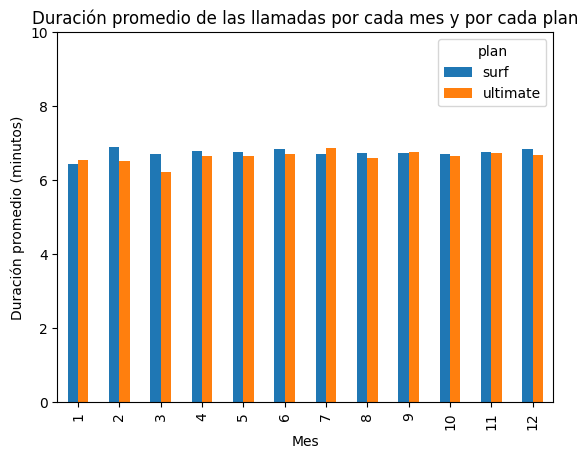

In [29]:
# Se compara la duración promedio de llamadas por cada plan y por cada mes.
## Fusionar users en calls mediante user_id. 
#print(calls.info())

duracion_llamadas = calls.merge(users[['user_id','plan']],
                                on = 'user_id',
                                how = 'inner')
#display(duracion_llamadas)

## Comparamos la duración promedio de llamadas por cada plan y por cada mes:
duracion_llamadas_plan = duracion_llamadas.pivot_table(
                                                        index='month',
                                                        columns='plan',
                                                        values='duration',
                                                        aggfunc='mean'
                                                       ).reset_index()
#display(duracion_llamadas_plan)
plt.figure(1)
duracion_llamadas_plan.plot(x='month', kind='bar')
plt.title('Duración promedio de las llamadas por cada mes y por cada plan')
plt.xlabel('Mes')
plt.ylabel('Duración promedio (minutos)')
plt.ylim([0,10])
plt.show()

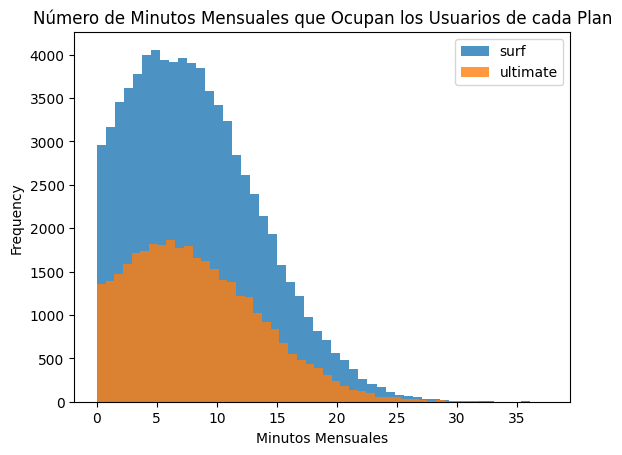

In [30]:
# Se compara el número de minutos mensuales que necesitan los usuarios de cada plan.
plt.figure(2)
# Trazamos el histograma del plan surf:
minutos_surf = duracion_llamadas[(duracion_llamadas['plan'] == 'surf') & (duracion_llamadas['duration'] != 0)]
minutos_surf['duration'].plot(kind='hist',
                              bins=50,
                              alpha = 0.8,
                              label = 'surf'
                             )

# Trazamos el histograma del plan ultimate:
minutos_ultimate = duracion_llamadas[(duracion_llamadas['plan'] == 'ultimate') & (duracion_llamadas['duration'] != 0)]
minutos_ultimate['duration'].plot(kind='hist',
                                  bins=50, 
                                  alpha=0.8,
                                  label = 'ultimate'
                                 )
plt.title('Número de Minutos Mensuales que Ocupan los Usuarios de cada Plan')
plt.xlabel('Minutos Mensuales')
plt.legend()
plt.show()

# NOTA: En el histograma eliminamos aquellos datos donde la duración era 0, ya que representaba un pico muy grande en los datos 
# y puede corresponder a clientes que aún o habían contratado algun plan o se habían dado de baja.

In [31]:
# Calcula la media y la varianza de la duración mensual de llamadas.
## Calculamos la media y la varianza de ambos planes para averiguar si los usuarios se comportan diferente segun el plan:
print('Media del plan surf:     ', minutos_surf['duration'].mean())
print('Media del plan ultimate: ', minutos_ultimate['duration'].mean())
print('\n')
print('Varianza del plan surf:     ', np.var(minutos_surf['duration']))
print('Varianza del plan ultimate: ', np.var(minutos_ultimate['duration']))

Media del plan surf:      8.391096643251577
Media del plan ultimate:  8.350246116948378


Varianza del plan surf:      28.72689751108129
Varianza del plan ultimate:  28.54918098099794


<Figure size 640x480 with 0 Axes>

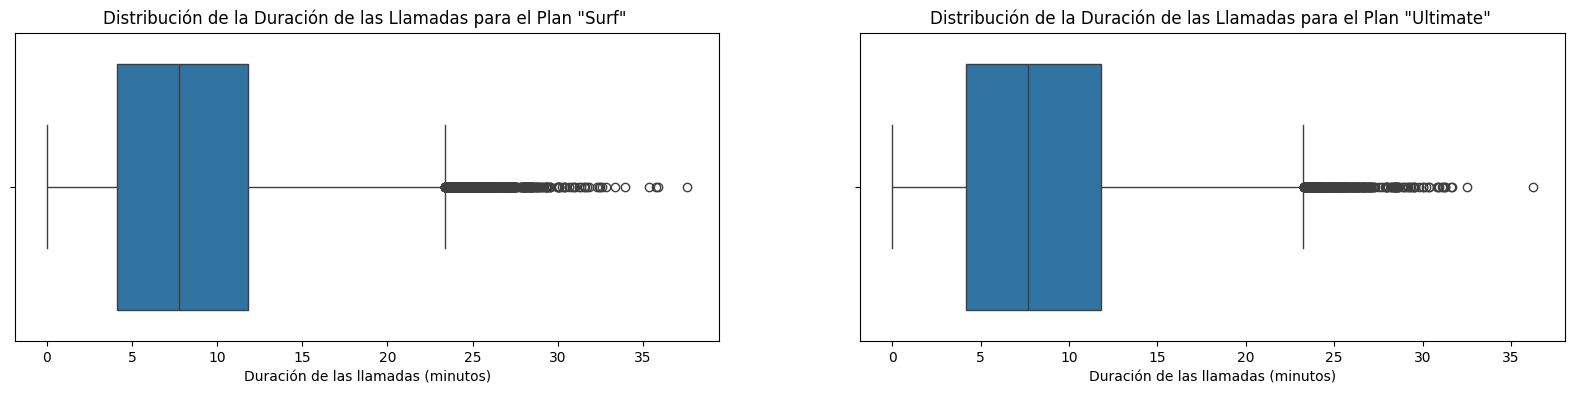

In [32]:
# Con undiagrama de caja, visualizamos la distribución de la duración mensual de llamadas
plt.figure(3)
plt.figure(figsize=(20, 4))

plt.subplot(121)
sns.boxplot(x = minutos_surf['duration'])
plt.title('Distribución de la Duración de las Llamadas para el Plan "Surf" ')
plt.xlabel('Duración de las llamadas (minutos)')

plt.subplot(122)
sns.boxplot(x = minutos_ultimate['duration'])
plt.title('Distribución de la Duración de las Llamadas para el Plan "Ultimate" ')
plt.xlabel('Duración de las llamadas (minutos)')
plt.show()

Podemos ver que los usuarios de ambos planes tienen comportamientos similares en las llamadas. Ambos grupos de usuarios hacen llamadas con duración promedio de 6 minutos.
Esto lo pordemos corroborar tambien con la distribución de la duración de las llamadas, pues las distribuciones son similares para ambos planes, aunque vemos que el plan surf tiene notablemente mas usuarios que el plan ultimate.

En cuanto a la dispersión de los datos, vemos que ambos planes cuentan con unas medidas estructurales de dispersión también bastante similares


### Mensajes

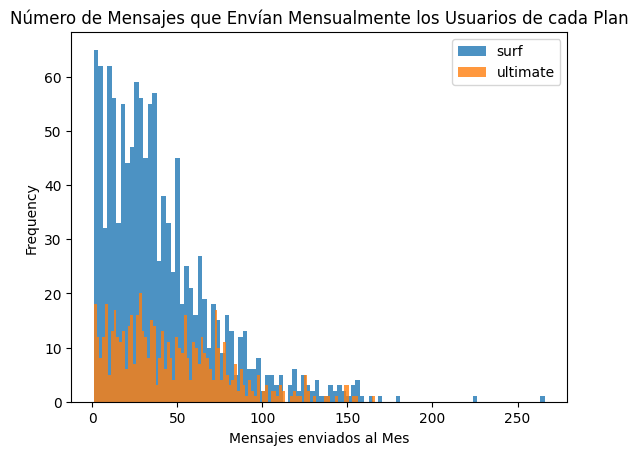

In [33]:
# Se compara el número de mensajes mensuales que tienden a enviar los usuarios de cada plan

##  La tabla "consumo_mensual_plan" obtenida anteriormente ya contiene esa información en las columnas ['user_id','plan','month','mensajes']:
mensajes_mensual_plan = consumo_mensual_plan[['user_id','plan','month','mensajes']]

## Filtramos para visualizar el número de mensajes por plan
numero_mensajes_surf = mensajes_mensual_plan[(mensajes_mensual_plan['plan']=='surf')&(mensajes_mensual_plan['mensajes']!=0)]
numero_mensajes_ultimate = mensajes_mensual_plan[(mensajes_mensual_plan['plan']=='ultimate')&(mensajes_mensual_plan['mensajes']!=0)]
# NOTA: En el histograma eliminamos aquellos datos donde el número de msjs era 0, ya que representaba un pico muy grande en los datos 
# y puede corresponder a clientes que aún o habían contratado algun plan o se habían dado de baja a lo largo del año.

## Debido a la longitud de las columnas a graficar, conviene más hacer un histograma:
#imprimimos los minimos y máximos para averiguar el numero adecuado de bins:
#print(numero_mensajes_surf['mensajes'].min(),numero_mensajes_surf['mensajes'].max())
#print(numero_mensajes_ultimate['mensajes'].min(),numero_mensajes_ultimate['mensajes'].max())
## Hacemos el histograma con los datos de 'month' y 'mensajes' de las tablas anteriores.
plt.figure(4)
numero_mensajes_surf['mensajes'].plot(kind='hist',
                                  bins=100, 
                                  alpha=0.8,
                                  label = 'surf'
                                 )
numero_mensajes_ultimate['mensajes'].plot(kind='hist',
                                  bins=100, 
                                  alpha=0.8,
                                  label = 'ultimate'
                                 )
plt.title('Número de Mensajes que Envían Mensualmente los Usuarios de cada Plan')
plt.xlabel('Mensajes enviados al Mes')
plt.legend()
plt.show()


In [34]:
# Hacemos estadística descriptiva para los mensajes enviados por mes:
## Calculamos la media y la varianza de ambos planes para averiguar si los usuarios se comportan diferente segun el plan:
print('Media de mensajes por mes del plan surf:     ', numero_mensajes_surf['mensajes'].mean())
print('Media de mensajes por mes del plan ultimate: ', numero_mensajes_ultimate['mensajes'].mean())
print('\n')
print('Varianza del plan surf:     ', np.var(numero_mensajes_surf['mensajes']))
print('Varianza del plan ultimate: ', np.var(numero_mensajes_ultimate['mensajes']))

Media de mensajes por mes del plan surf:      40.10965630114566
Media de mensajes por mes del plan ultimate:  46.29623287671233


Varianza del plan surf:      1090.4511506183685
Varianza del plan ultimate:  1083.3249173156314


<Figure size 640x480 with 0 Axes>

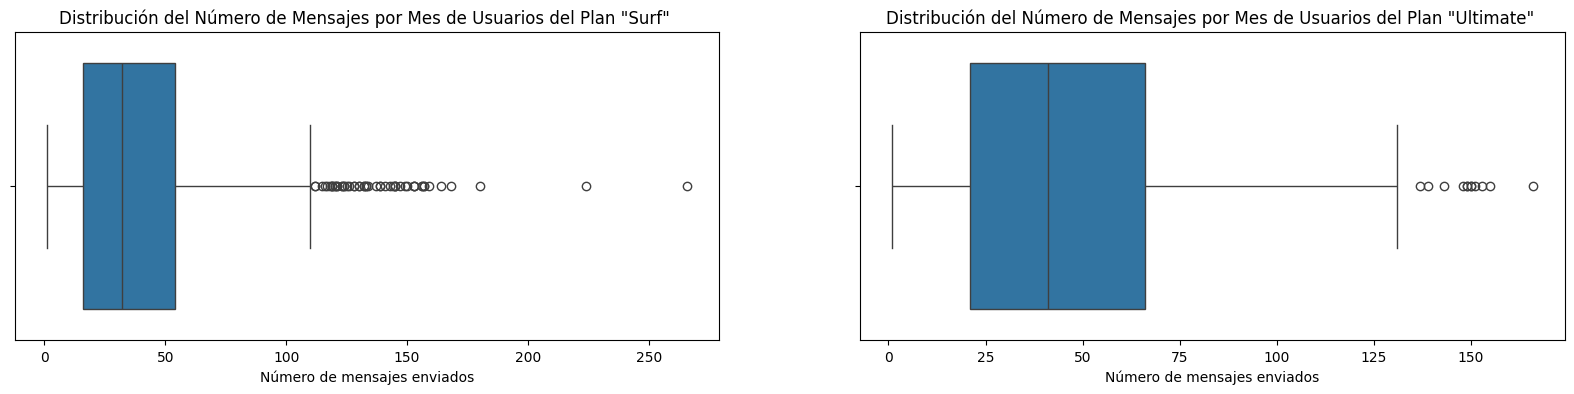

In [35]:
# Analizamos la dispersión de los datos.
plt.figure(5)
plt.figure(figsize=(20, 4))

plt.subplot(121)
sns.boxplot(x = numero_mensajes_surf['mensajes'])
plt.title('Distribución del Número de Mensajes por Mes de Usuarios del Plan "Surf" ')
plt.xlabel('Número de mensajes enviados')

plt.subplot(122)
sns.boxplot(x = numero_mensajes_ultimate['mensajes'])
plt.title('Distribución del Número de Mensajes por Mes de Usuarios del Plan "Ultimate" ')
plt.xlabel('Número de mensajes enviados')
plt.show()

Vemos que los dos planes distintos que ofrece la compañia, la mayoría de usuarios tiende a enviar menos de 50 mensajes al mes, sin importar que el plan ultimate ofrezca 1000 mensajes al mes, pues en realidad, pocos son los usuarios que superan los 250 mensajes al mes.
La media de mensajes mensuales para ambos planes cae alrededor de los 45 mensajes al mes en ambos casos; en ambas distribuciones, las varianzas tambien son casi iguales, haciendo que las distribuciones sean muy similares y por lo tanto, que también lo sea el comportamiento de los usuarios sin importar el plan. Sin embargo, en los boxplots podemos ver que el plan surf presenta algunos valores atípicos más alejados. Para los usuarios que caigan en esa región, el plan ultimate cubriria mejor sus necesidades de mensajes

### Internet

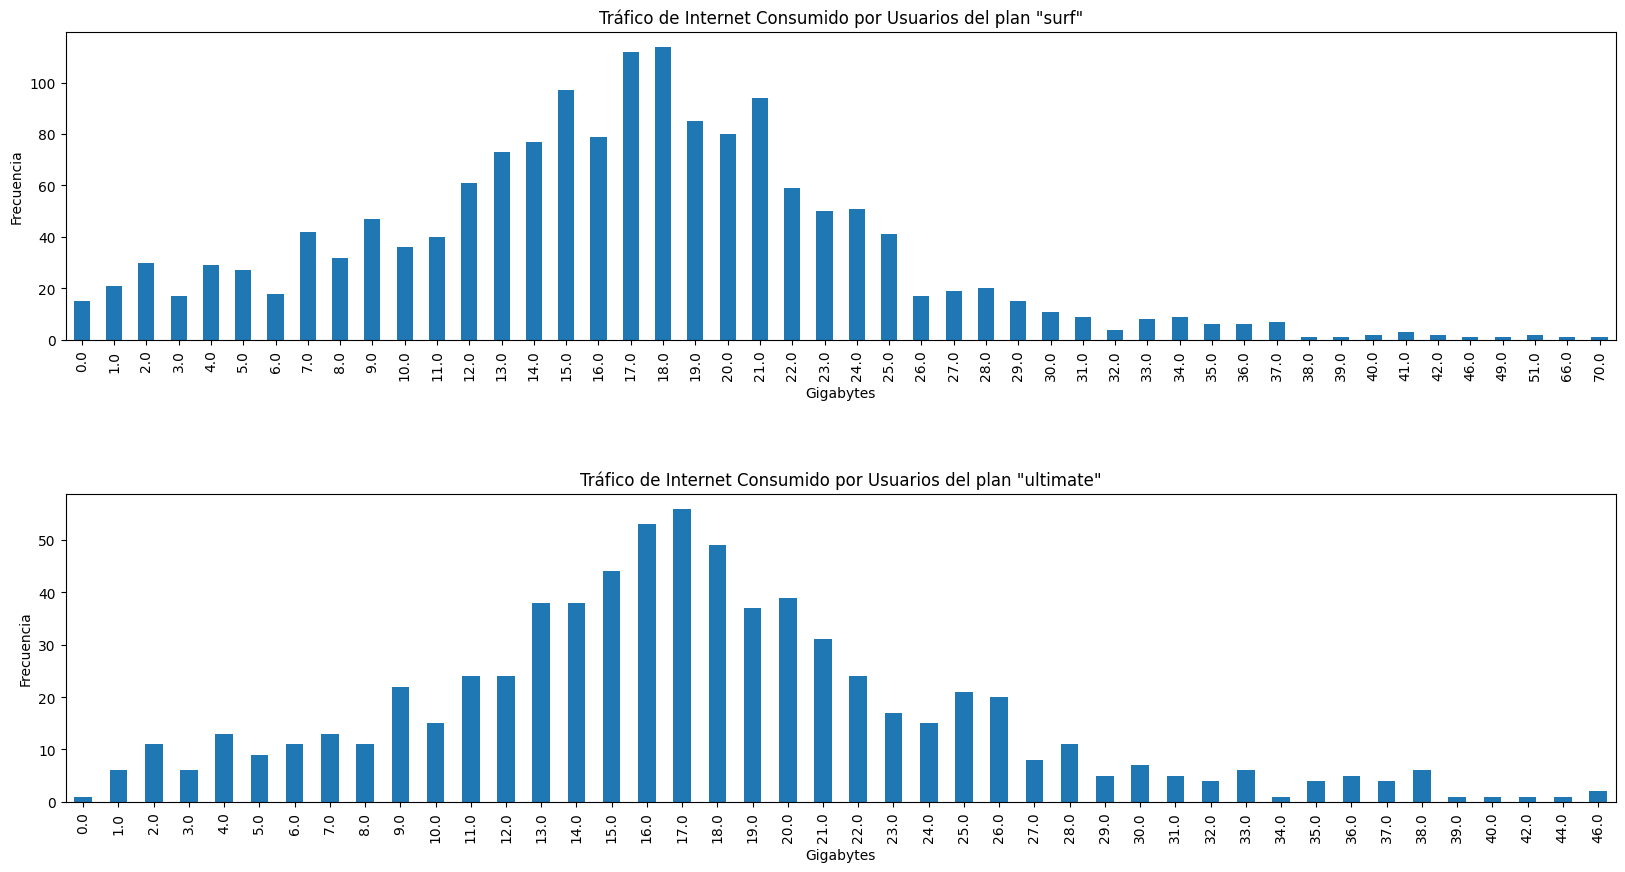

In [36]:
# Se compara la cantidad de tráfico de Internet consumido por usuarios por plan

## La tabla consumo_mensual_plan ya contienen esos datos en las columnas:
internet_mensual_plan = consumo_mensual_plan[['user_id', 'plan', 'month', 'gigabytes']]
## Filtramos para obtener el trafico mensual de internet usado por los usuarios
internet_mensual_surf = internet_mensual_plan[(internet_mensual_plan['plan']=='surf')]
internet_mensual_ultimate = internet_mensual_plan[(internet_mensual_plan['plan']=='ultimate')]
# display(internet_mensual_plan)

## Hacemos una gráfica de barras.
plt.figure(6, figsize=(20, 10))
plt.subplot(211)
internet_mensual_surf['gigabytes'].value_counts().sort_index().plot(kind='bar')
plt.title('Tráfico de Internet Consumido por Usuarios del plan "surf"')
plt.xlabel('Gigabytes')
plt.ylabel('Frecuencia')

plt.subplot(212)
internet_mensual_ultimate['gigabytes'].value_counts().sort_index().plot(kind='bar')
plt.title('Tráfico de Internet Consumido por Usuarios del plan "ultimate"')
plt.xlabel('Gigabytes')
plt.ylabel('Frecuencia')
plt.subplots_adjust(hspace=0.5)
plt.show()


In [37]:
# Hacemos estadística descriptiva para los mensajes enviados por mes:
## Calculamos la media y la varianza de ambos planes para averiguar si los usuarios se comportan diferente segun el plan:
print('Media de tráfico de internet del plan surf:     ', internet_mensual_surf['gigabytes'].mean())
print('Media de tráfico de internet del plan ultimate: ', internet_mensual_ultimate['gigabytes'].mean())
print('\n')
print('Varianza del plan surf:     ', np.var(internet_mensual_surf['gigabytes']))
print('Varianza del plan ultimate: ', np.var(internet_mensual_ultimate['gigabytes']))

Media de tráfico de internet del plan surf:      16.670692943420217
Media de tráfico de internet del plan ultimate:  17.306944444444444


Varianza del plan surf:      61.54444942447024
Varianza del plan ultimate:  58.748840663580246


<Figure size 640x480 with 0 Axes>

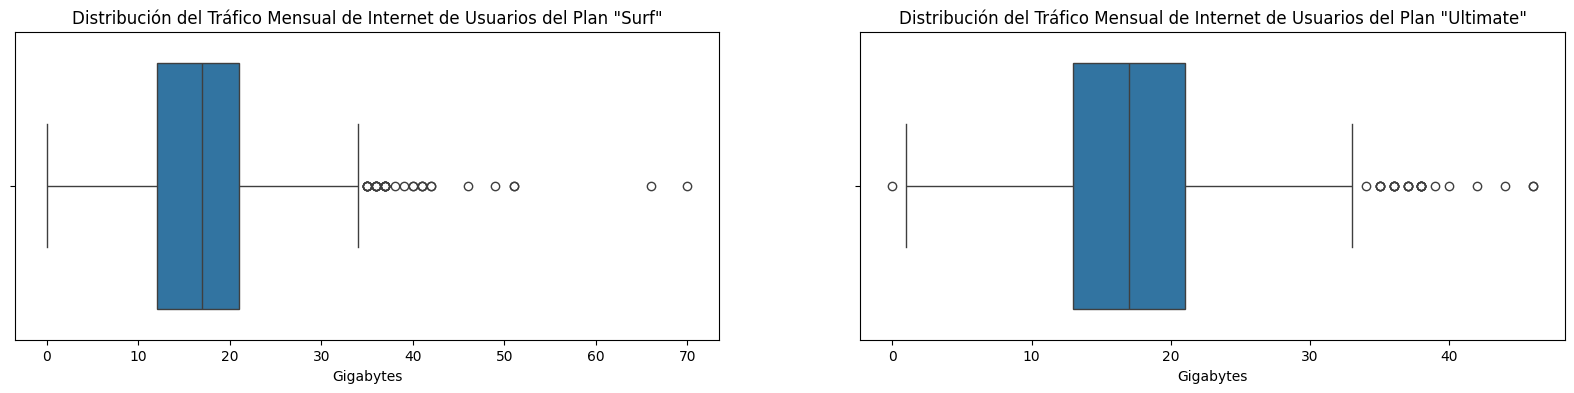

In [38]:
# Analizamos la dispersión de los datos.
plt.figure(7)
plt.figure(figsize=(20, 4))

plt.subplot(121)
sns.boxplot(x = internet_mensual_surf['gigabytes'])
plt.title('Distribución del Tráfico Mensual de Internet de Usuarios del Plan "Surf"')
plt.xlabel('Gigabytes')

plt.subplot(122)
sns.boxplot(x = internet_mensual_ultimate['gigabytes'])
plt.title('Distribución del Tráfico Mensual de Internet de Usuarios del Plan "Ultimate"')
plt.xlabel('Gigabytes')
plt.show()

Para ambos planes se cumple que la media de tráfico de internet consumido es de 17 gb mensuales, sin importar el plan.
Esto podría representar un problema para los usuarios del plan surf, pues, de consumir el trafico promedio, los usuarios se verian en la necesidad de pagar un monto extra, ya que su plan solo cubre 15 gb.

Y gracias a los boxplots, vemos que este comportamiento es muy común en los usuarios del plan surf, pues los datos estan mas dispersos.



## Ingreso

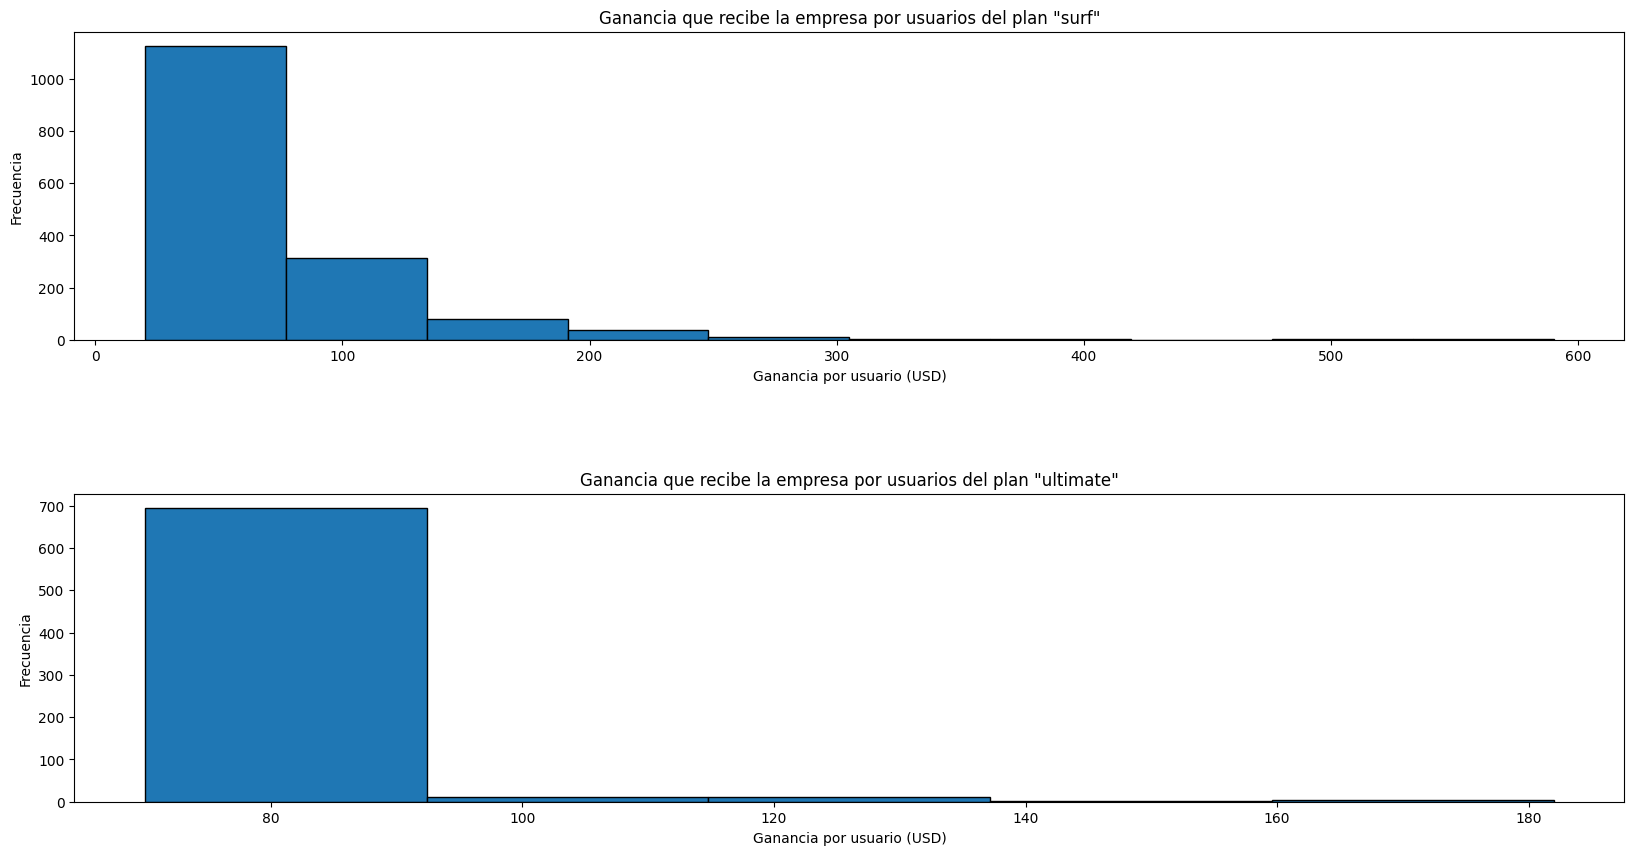

In [39]:
# Analizamos el gasto mensual que tienen los clientes para cada plan.
## La tabla ingreso_mensual_usuarios ya contienen esos datos en las columnas:
#display(ingreso_mensual_usuarios)

## Filtramos para obtener el ingreso mensual de ambos planes.
ingreso_mensual_surf = ingreso_mensual_usuarios[(ingreso_mensual_usuarios['plan_name']=='surf')]
ingreso_mensual_ultimate = ingreso_mensual_usuarios[(ingreso_mensual_usuarios['plan_name']=='ultimate')]
#display(ingreso_mensual_surf['cargo_total'].max())
#display(ingreso_mensual_ultimate['cargo_total'].min())

# La columna 'cargo_total' tiene el gasto de cada cliente y por lo tanto, la ganancia total de la empresa:
plt.figure(8, figsize=(20,10))
plt.subplot(2,1,1)
plt.hist(ingreso_mensual_surf['cargo_total'], bins=10, edgecolor='black') 
plt.title('Ganancia que recibe la empresa por usuarios del plan "surf"')
plt.ylabel('Frecuencia')
plt.xlabel('Ganancia por usuario (USD)')

plt.subplot(2,1,2)
plt.hist(ingreso_mensual_ultimate['cargo_total'], bins=5, edgecolor='black') 
plt.title('Ganancia que recibe la empresa por usuarios del plan "ultimate"')
plt.ylabel('Frecuencia')
plt.xlabel('Ganancia por usuario (USD)')
plt.subplots_adjust(hspace=0.5)
plt.show()

In [40]:
# Obtenemos las medidas de estadística descriptiva de los ingresos.
## Calculamos la media y la varianza de las ganancias de ambos planes
   #para averiguar si los usuarios se comportan diferente segun el plan:
print('Media de ganancia mensual por usuarios del plan surf:     ', ingreso_mensual_surf['cargo_total'].mean())
print('Media de ganancia mensual por usuarios del plan ultimate: ', ingreso_mensual_ultimate['cargo_total'].mean())
print('\n')
print('Varianza de las ganancias por usuario del plan surf:     ', np.var(ingreso_mensual_surf['cargo_total']))
print('Varianza de las ganancias por usuario del plan ultimate:     ', np.var(ingreso_mensual_ultimate['cargo_total']))

Media de ganancia mensual por usuarios del plan surf:      60.706408137317226
Media de ganancia mensual por usuarios del plan ultimate:  72.31388888888888


Varianza de las ganancias por usuario del plan surf:      3065.8848438690247
Varianza de las ganancias por usuario del plan ultimate:      129.66814043209877


<Figure size 640x480 with 0 Axes>

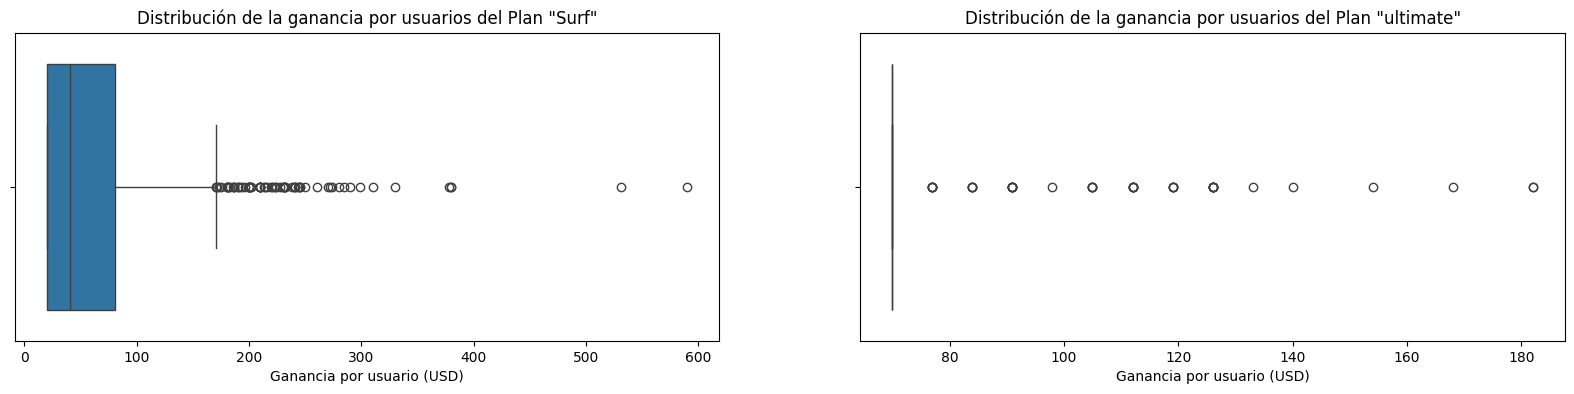

In [41]:
# Analizamos la dispersión de los datos
plt.figure(9)
plt.figure(figsize=(20, 4))

plt.subplot(121)
sns.boxplot(x = ingreso_mensual_surf['cargo_total'])
plt.title('Distribución de la ganancia por usuarios del Plan "Surf"')
plt.xlabel('Ganancia por usuario (USD)')

plt.subplot(122)
sns.boxplot(x = ingreso_mensual_ultimate['cargo_total'])
plt.title('Distribución de la ganancia por usuarios del Plan "ultimate"')
plt.xlabel('Ganancia por usuario (USD)')
plt.show()

Vemos una clara diferencia en los ingresos que obtiene la empresa segun el plan, pues mientras que los usuarios del plan ultimate poca dispersión y una media cercana a la tarifa del plan, los usuarios de surf tienen una media 60.7, es decir, pagan mas por servicios extra (ya sea minutos, mensajes o gigabytes).

Los valores atipicos en los boxplots confirman la gran dispersión que se presenta en el plan surf, lo cual contrasta con la poca varianza del plan ultimate y los pocos valores atípicos del mismo

## Prueba las hipótesis estadísticas

Para verificar que, en efecto, los ingresos promedio obtenidos por plan son diferentes se hará una prueba de hipótesis. 

In [42]:
# Suponemos entonces que nuestra hipótesis nula es que "no hay diferencia entre los ingresos promedio de los planes".
print('Los valores de ingresos promedio son:')
print('-> Media de ganancia mensual por usuarios del plan surf:     ', ingreso_mensual_surf['cargo_total'].mean())
print('-> Media de ganancia mensual por usuarios del plan ultimate: ', ingreso_mensual_ultimate['cargo_total'].mean())
print('\n','-'*20, 'Prueba de hipótesis', '-'*20)
# Hacemos una prueba de Hipótesis sobre la igualdad de las medias de dos poblaciones independientes:
alpha = 0.05 # Proponemos un valor de significancia del 5%
results = st.ttest_ind(ingreso_mensual_surf['cargo_total'], ingreso_mensual_ultimate['cargo_total']) 

print('Valor p: ', results.pvalue) # se extrae el valor p

if results.pvalue < alpha: # Se compara el valor p con el umbral alpha
    print("Rechazamos la hipótesis nula, por lo tanto, las ganancias SON diferentes de acuerdo al plan.")
else:
    print("No podemos rechazar la hipótesis nula.")


Los valores de ingresos promedio son:
-> Media de ganancia mensual por usuarios del plan surf:      60.706408137317226
-> Media de ganancia mensual por usuarios del plan ultimate:  72.31388888888888

 -------------------- Prueba de hipótesis --------------------
Valor p:  2.862674510698644e-08
Rechazamos la hipótesis nula, por lo tanto, las ganancias SON diferentes de acuerdo al plan.


Haremos otra prueba de hipótesis, esta vez para determinar si los ingresos promedio de una región específica (NY-NJ), son distintos a los ingresos promedio de las otras regiones de la base de datos.

In [43]:
# A la tabla ingreso_mensual_usuarios fusionamos la información de la tabla users[['user_id','ny_nj']]:
ingreso_mensual_regiones = ingreso_mensual_usuarios.merge(users[['user_id','ny_nj']], on='user_id', how='left')
#display(ingreso_mensual_regiones)

# ip_NY_NJ: base de datos para el ingreso promedio de los usuarios del área NY-NJ, 
ip_NY_NJ = ingreso_mensual_regiones[ingreso_mensual_regiones['ny_nj']==True]['cargo_total']
print(f'Longitud de la muestra de la región NY_NJ: {len(ip_NY_NJ)}')
ip_otras_reg = ingreso_mensual_regiones[ingreso_mensual_regiones['ny_nj']==False]['cargo_total']
print(f'Longitud de la muestra de las otras regiones: {len(ip_otras_reg)}\n')

print('Estos son los valores promedio que vamos a poner a prueba:')
print('-> Media de ganancia mensual para usuarios de región NY-NJ:     ', ip_NY_NJ.mean())
print('-> Media de ganancia mensual para usuarios de otras regiones:   ', ip_otras_reg.mean())
print('\n','-'*20, 'Prueba de hipótesis', '-'*20, '\n')

# Nuestra hipótesis nula será que las medias de ambas poblaciones son iguales.
# Nuevamente hacemos una prueba de hipotesis sobre igualdad de medias de 2 poblaciones independientes:
print('Establecemos un nivel de significancia del 0.03, ya que la longitud de ambas muestras es un segmento muy pequeño de ambas poblaciones')
alpha = 0.03

print('-'*20, 'original')
results = st.ttest_ind(ip_NY_NJ, ip_otras_reg) 

print('Valor p: ', results.pvalue) # se extrae el valor p

if results.pvalue < alpha: # Se compara el valor p con el umbral alpha
    print("Rechazamos la hipótesis nula, por lo tanto, las ganancias, en efecto, SON diferentes en la región NY-NJ")
else:
    print("No podemos rechazar la hipótesis nula.")

print('\n','-'*20, 'Con varianza distinta')
results3 = st.ttest_ind(ip_NY_NJ, ip_otras_reg, equal_var = False) 

print('Valor p: ', results3.pvalue) # se extrae el valor p

if results3.pvalue < alpha: # Se compara el valor p con el umbral alpha
    print("Rechazamos la hipótesis nula, por lo tanto, las ganancias, en efecto, SON diferentes en la región NY-NJ")
else:
    print("No podemos rechazar la hipótesis nula.")

Longitud de la muestra de la región NY_NJ: 377
Longitud de la muestra de las otras regiones: 1916

Estos son los valores promedio que vamos a poner a prueba:
-> Media de ganancia mensual para usuarios de región NY-NJ:      59.921352785145885
-> Media de ganancia mensual para usuarios de otras regiones:    65.2227713987474

 -------------------- Prueba de hipótesis -------------------- 

Establecemos un nivel de significancia del 0.03, ya que la longitud de ambas muestras es un segmento muy pequeño de ambas poblaciones
-------------------- original
Valor p:  0.043557431621342436
No podemos rechazar la hipótesis nula.

 -------------------- Con varianza distinta
Valor p:  0.0335256158853001
No podemos rechazar la hipótesis nula.


## Conclusión general

1. Con el análisis estadístico del comportamiento de los usuarios en llamadas, mensajes e internet por planes, se concluye que.
    - Para llamadas, en ambos planes el numero de llamadas mensuales promedio es alrededor de 6. La media de minutos mensuales es de alrededor de 8.3 y la varianza de alrededor de 28 en ambos casos.
    - Para el envío de mensajes, el comportamiento de media y varianza es igualmente muy similar. Sin embargo, algunos usuarios del plan surf podemos considerarlos atípicos, pues envian muchos más mensajes de los que cubre su plan. A estos usuarios probablemente se les podría convencer de cambiar su plan a ultimate, o bien, adaptar el plan surf para cubrir las necesidades de estos usuarios.
    - Para el uso de internet, vemos que no hay diferencia en el comportamiento de los usuarios, ambos grupos de usuarios usan alrededor de 17 GB mensuales y y el trafico de internet mensual tiene una varianza de alrededor de 60. Sin embargo, es evidente que para el plan surf, esta media supera a los datos incluidos en el plan, de modo que muchos usuarios terminan pagando un costo extra por el uso de internet.


2. Con el análisis estadístico de la ganancia vemos que las ganancias para cada plan tienen diferente media y varianza. Esto lo confirma la prueba de hipótesis, que nos dice que en efecto, hay una diferencia entre las ganancias de ambos planes.
    - Con estos resultados se concluye que aunque el ingreso promedio mensual es un poco mayor en el plan ultimate, el plan surf tiene más usuarios, y dado que ambos grupos de usuarios demandan un plan de datos, minutos y mensajes muy similar, *podría recomendar enfocar las estrategias de publicidad y marketing a este plan y tambien, extender la cobertura del plan surf en gigas y megas, para atender a mejor a las necesidades de la población de usuarios en general, pues asi, los usuarios estarán mas convencidos de contratar el plan al no verse en la necesidad de pagar cuotas extras.*

 
3. De igual forma, al hacer una prueba de hipotesis para averiguar si las ganancias promedio de la región NY-NJ son diferentes a las de las otras regiones juntas, obtenemos como resultado una diferencia en estos ingresos. 
    - Con esto se comprueba que los ingresos obtenidos de una región densamente poblada como lo es NY-NJ, no pueden compararse con los ingresos obtenidos de usuarios de otras regiones, pues la diferencia entre ingresos es claramente significativa e incluso mayor para las otras regiones, de modo que, si queremos igualar las ganancias en la región NY-NJ, una estrategía de ventas y/o publicidad se debería enfocar en este sector.